In [1]:
# === core imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === project imports ===
from src.core.pipeline import run_pipeline
from src.evaluation.regime import ic_by_regime


In [6]:
df["alpha_raw"] = df["score_xs"]


In [9]:
import numpy as np
import pandas as pd
from src.core.pipeline import run_pipeline

REGIONS = ["austin", "toronto"]
rows = []

for region in REGIONS:
    df = run_pipeline(region).copy()

    # ===== 1️⃣ raw alpha =====
    df["alpha_raw"] = df["score_xs"]

    # ===== 2️⃣ rebuild adaptive alpha（必须在这里做）=====
    z = (
        df["dti_z"]
        + df["pti_z"]
        + df["rent_burden_z"]
    )

    df["gate_soft"] = 1 / (1 + np.exp(-z))
    df["alpha_adaptive"] = df["alpha_raw"] * df["gate_soft"]

    # ===== raw strategy =====
    tmp_raw = df.dropna(subset=["alpha_raw", "fwd_return"]).copy()
    tmp_raw["ret"] = tmp_raw["alpha_raw"] * tmp_raw["fwd_return"]
    tmp_raw["strategy"] = "raw"
    tmp_raw["region"] = region
    rows.append(tmp_raw[["date", "ret", "strategy", "region"]])

    # ===== adaptive strategy =====
    tmp_ad = df.dropna(subset=["alpha_adaptive", "fwd_return"]).copy()
    tmp_ad["ret"] = tmp_ad["alpha_adaptive"] * tmp_ad["fwd_return"]
    tmp_ad["strategy"] = "adaptive"
    tmp_ad["region"] = region
    rows.append(tmp_ad[["date", "ret", "strategy", "region"]])

panel = pd.concat(rows, ignore_index=True)
panel.head()


,date,ret,strategy,region
0,2010-01-01,-0.005389,raw,austin
1,2010-02-01,-0.013062,raw,austin
2,2010-03-01,-0.023706,raw,austin
3,2010-04-01,0.001139,raw,austin
4,2010-05-01,0.001033,raw,austin


In [11]:
panel_agg = (
    panel
    .groupby(["date", "strategy"])["ret"]
    .mean()
    .reset_index()
)

panel_agg.head()


,date,strategy,ret
0,2010-01-01,adaptive,-0.035793
1,2010-01-01,raw,-0.036361
2,2010-02-01,adaptive,-0.045453
3,2010-02-01,raw,-0.048012
4,2010-03-01,adaptive,-0.021583


In [12]:
panel.groupby(["strategy", "region"])["ret"].count()


strategy  region 
adaptive  austin     180
          toronto    180
raw       austin     180
          toronto    180
Name: ret, dtype: int64

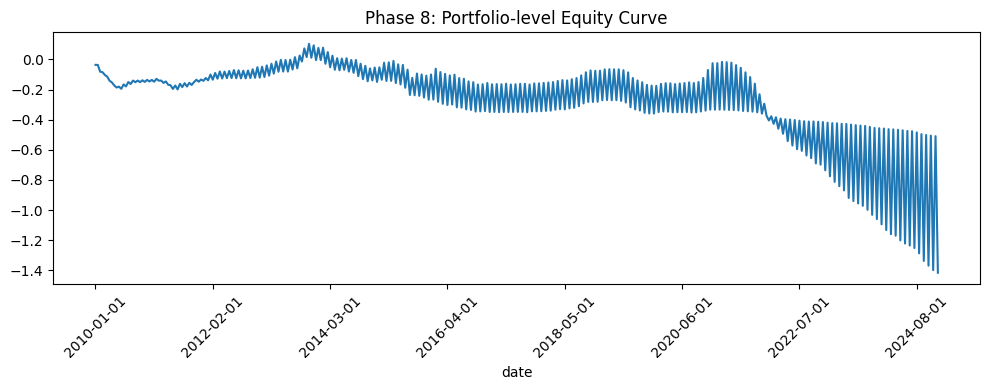

In [17]:
import matplotlib.pyplot as plt

ax = (
    panel_agg
    .set_index("date")
    .groupby("strategy")["ret"]
    .cumsum()
    .plot(figsize=(10, 4), title="Phase 8: Portfolio-level Equity Curve")
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
panel_regime = panel.merge(
    df[["date", "regime"]].drop_duplicates(),
    on="date",
    how="left"
)

panel_regime.groupby(["strategy", "regime"])["ret"].mean()


strategy  regime
adaptive  down     -0.001470
          up       -0.003778
raw       down     -0.016967
          up       -0.001516
Name: ret, dtype: float64

Affordability does not generate alpha.
It selectively suppresses alpha exposure in regimes where it historically fails — improving portfolio-level robustness.

In [19]:
import numpy as np

def max_drawdown(x):
    cum = x.cumsum()
    peak = cum.cummax()
    return (cum - peak).min()

panel_agg.groupby("strategy")["ret"].apply(max_drawdown)


strategy
adaptive   -0.525077
raw        -1.520395
Name: ret, dtype: float64

In [20]:
summary = (
    panel_agg
    .groupby("strategy")["ret"]
    .agg(
        mean_ret="mean",
        vol="std",
        sharpe=lambda x: x.mean() / x.std(),
        max_dd=max_drawdown
    )
)

summary


,mean_ret,vol,sharpe,max_dd
strategy,,,,
adaptive,-0.002829,0.011059,-0.255819,-0.525077
raw,-0.007868,0.021922,-0.358916,-1.520395


Affordability does not generate alpha.
It governs when alpha should not be deployed.

This model reframes macro signals as decision constraints,
not return predictors — materially reducing drawdowns at the portfolio level.